# Data-X Project: Electricity Price Prediction
## Feature Modeling Group: Machine Learning Optimization Pipeline

Description of Notebook

Retail electricity prices across different regions will have varying dependencies on all kinds of other signals in the energy marketplace. This notebook is an "pipeline" that integrates any available regional data (as well as national data) into an automated feature and machine learning model selection routine. The process is highly iterative and computationally intensive. However, the prediction of long term retail electricity prices is not time sensitive. It is not particularly desirable, but not necessarily awful for this notebook to run over the course of hours or days. 

The eventual output is visualizations of different models' average performances across ranges of feature combinations and hyperparameter combinations. The best-performing-on-average combination or combinations of [model X feature grouping X hyperparameter set] will be used (on their own or averaged) to make future predicitions of energy price. Other high performing combinations will combine to form tolerance bands for the prediction.

Team Members: Aaron Drew, Arbaaz Shakir, JOhn Stuart, Adam Yankelevits, Eric Yehl

**Note:** This notebook needs to be launched by typing: 
jupyter lab Project.ipynb --NotebookApp.iopub_data_rate_limit=10000000000

## Import Libraries

Import open source packages and files defining custom functions.

In [48]:
%run helper_functions.py 

## Data Collection

Source data streams for a particular region (probably manual).

## Data Aggregation

Stitch many data streams into a Google Sheet and create a pandas dataframe by importing from Sheets API.

Columns: Features

Rows: Timestamps

In [110]:
raw_data = import_sheet('TOY DATA')
raw_data.head()

,AllFuelsGen,AvgRelHum,AvgTemp,CA_GDP,ElecNatGasCons,GDP,GeothermalGen,HydroGen,IndepGen,LargeHydroCap,...,NatGasPrice,NuclearGen,Price,RenewablesGen,SolarPVCap,TotElecNetGen,TotNatGasCons,TotRetailElecSales,TotalElecCap,WindCap
0,16618.89,51.45,52.22,1638.07,94388.27,1638.07,1085.73,1590.10,1085.78,11848.00,...,8.91,2380.00,8.71,1717.40,2.0,332.49,2677.00,21744.32,55364.00,1534.00
1,14380.39,71.37,50.04,1637.15,82259.19,1637.15,951.16,1290.01,951.21,11836.75,...,7.08,2229.87,9.63,1504.66,2.0,282.94,2309.46,18305.56,55540.83,1534.83
2,15848.63,77.43,56.12,1636.24,87836.61,1636.24,1052.63,1764.77,1052.67,11825.50,...,6.10,2468.63,9.89,1788.32,2.0,300.71,2246.63,21351.41,55717.67,1535.67
3,15841.02,72.80,54.87,1635.32,84775.23,1635.32,966.04,2096.46,966.08,11814.25,...,6.30,2318.67,9.88,1797.49,2.0,278.08,1807.17,18855.60,55894.50,1536.50
4,16874.50,72.58,66.45,1634.40,87603.94,1634.40,960.34,3045.22,960.37,11803.00,...,5.77,1667.93,9.82,1831.97,2.0,300.49,1522.38,19862.26,56071.33,1537.33


In [4]:
raw_data_desc = raw_data.describe()
raw_data_desc

,AllFuelsGen,AvgMaxTemp,AvgRelHum,AvgTemp,CA_GDP,ElecNatGasCons,GDP,GeothermalGen,HydroGen,IndepGen,...,NatGasPrice,NuclearGen,Price,RenewablesGen,SolarPVCap,TotElecNetGen,TotNatGasCons,TotRetailElecSales,TotalElecCap,WindCap
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,...,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,16733.593467,76.970352,53.418442,64.354472,1951.903216,66942.764422,1951.622060,1053.368342,2563.247789,981.527940,...,6.059347,2366.178844,13.092261,2542.327688,1193.349246,335.190402,2010.338844,21356.018593,62465.610553,3063.864322
std,2331.269383,10.993670,10.673425,8.244892,184.680337,16069.179398,184.051987,52.863043,1128.504469,47.180997,...,1.875782,756.576053,1.778003,938.695213,2255.885948,34.061656,414.937334,2262.087435,20924.741944,1821.865208
min,12303.540000,57.160000,23.960000,49.630000,1627.980000,30739.270000,1627.980000,873.540000,639.630000,811.910000,...,3.220000,793.300000,8.710000,1504.660000,0.000000,278.080000,1368.370000,16962.600000,0.000000,0.000000
25%,15021.315000,67.215000,46.970000,56.905000,1848.945000,55497.115000,1855.410000,1022.135000,1718.575000,955.560000,...,4.640000,1655.670000,11.900000,1924.480000,2.000000,308.755000,1666.740000,19804.795000,60123.125000,1879.125000
50%,16161.550000,75.280000,53.250000,63.710000,1960.720000,65542.840000,1959.440000,1057.370000,2439.490000,986.040000,...,5.700000,2435.900000,12.700000,2202.790000,5.750000,327.400000,1899.910000,20947.430000,67022.000000,2439.750000
75%,18042.225000,87.590000,60.070000,72.775000,2036.950000,78873.125000,2036.950000,1090.035000,3279.280000,1015.935000,...,7.165000,3112.295000,14.270000,2792.155000,711.000000,356.295000,2293.580000,22695.635000,73522.125000,4845.125000
max,24663.870000,98.060000,81.930000,82.260000,2335.000000,108594.580000,2330.000000,1147.970000,5827.190000,1085.780000,...,12.480000,3382.210000,17.550000,5532.790000,8619.000000,421.800000,3204.130000,27517.480000,79068.000000,5984.000000


In [111]:
raw_data = raw_data[0:100]

In [45]:
mean_std_normed_data = (raw_data-raw_data.mean())/raw_data.std()
min_max_normed_data = (raw_data-raw_data.min())/(raw_data.max()-raw_data.min())

## Data Cleaning

Fill in missing values using interpolation, or condense high resolution data.

## Data Transformation

Convert data signals to smooth moving averages, removing seasonal oscillations.

Track average, seasonal peaks, and seasonal troughs.

Normalize all signals (maybe). 

Find best fit polynomial for seasonal deviation over the course of one year.

## Exploratory Data Analysis with Correlation Matrices

### Pearson correlation matrix "heat map" for colinearity between all features.

In [6]:
# Close figures in the background
plt.close("all")

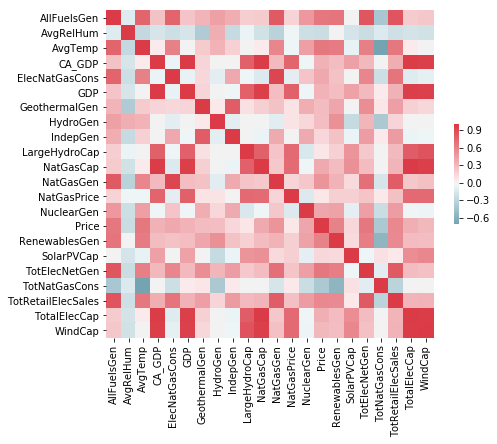

In [118]:
plt.close("all")
%run helper_functions.py 
reg_heatmap = reg_heat_map(raw_data)
reg_heatmap

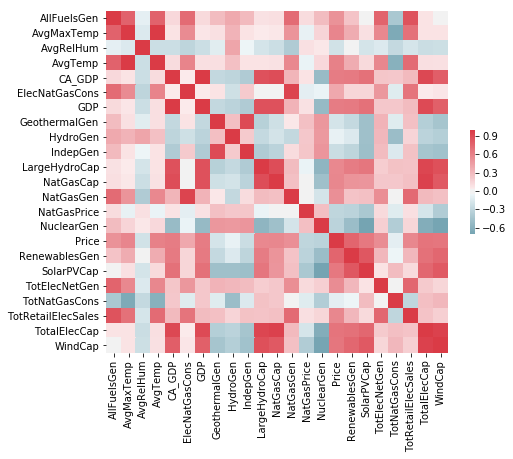

In [48]:
plt.close("all")
%run helper_functions.py 
reg_heatmap = reg_heat_map(min_max_normed_data)
reg_heatmap

### Time displaced correlations of all features with price

Displace (advance) feature signals by n months. This will line up past signals with future prices. Truncate n months at the end of feature signals and n months at the beginning of price signals.

/Users/eric_yehl/eric_yehl-data-x-s18/EPP-Feature-Modeling/helper_functions.py:94: RuntimeWarning: Degrees of freedom <= 0 for slice
  time_corr[i,j] = np.round(np.cov(comp_var_sig,feature_sig)[0,1]/(np.std(comp_var_sig)*np.std(feature_sig)),2)
/Users/eric_yehl/anaconda3/envs/data-x/lib/python3.6/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/eric_yehl/anaconda3/envs/data-x/lib/python3.6/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/eric_yehl/anaconda3/envs/data-x/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/eric_yehl/anaconda3/envs/data-x/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/eric_yehl/e

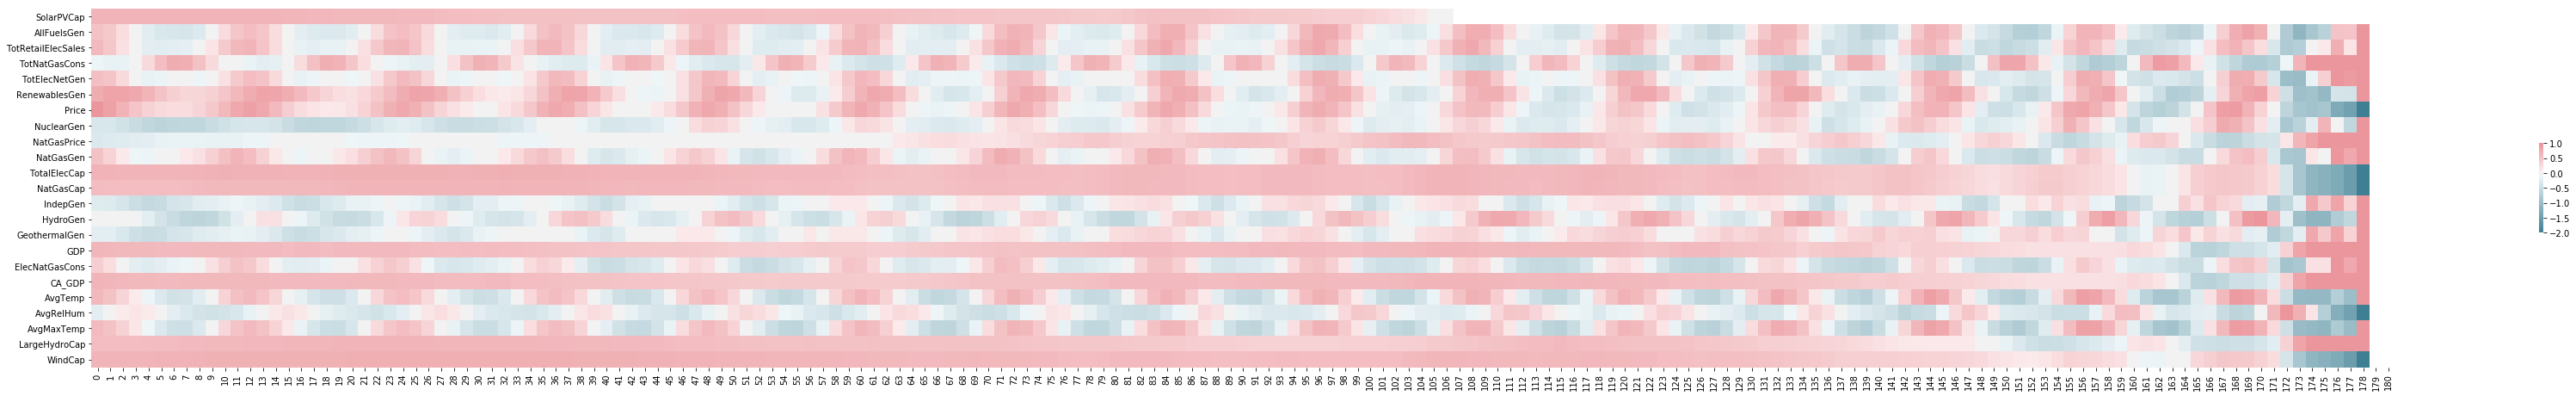

In [52]:
plt.close("all")
%run helper_functions.py 
time_heatmap = time_heat_map(raw_data,'Price',months=180)
time_heatmap

## Data Visualization

Plot features against each other in 3+ dimensions.

## Feature Construction

Create new features using derivatives (perhaps first interpolating with polynomials, then taking the derivative(s) of these instead of using finite difference), powers, time offsets, and perhaps products and quotients of these. Do this intelligently so as not to create an intractable amount of combinations.

In [125]:
%run helper_functions.py 
trimmed_data, thrown_out = distinct_features(raw_data,corr_high = .8,look_back=36)
print(str(thrown_out)+' features removed')
trimmed_data.head()

Matching:
['CA_GDP', 'GDP', 'NatGasCap', 'TotalElecCap', 'WindCap']
Removed:
['CA_GDP', 'GDP', 'TotalElecCap', 'WindCap']
4 features removed


,AllFuelsGen,AvgRelHum,AvgTemp,ElecNatGasCons,GeothermalGen,HydroGen,IndepGen,LargeHydroCap,NatGasCap,NatGasGen,NatGasPrice,NuclearGen,Price,RenewablesGen,SolarPVCap,TotElecNetGen,TotNatGasCons,TotRetailElecSales
0,16618.89,51.45,52.22,94388.27,1085.73,1590.10,1085.78,11848.00,30375.00,10192.49,8.91,2380.00,8.71,1717.40,2.0,332.49,2677.00,21744.32
1,14380.39,71.37,50.04,82259.19,951.16,1290.01,951.21,11836.75,30567.83,8870.58,7.08,2229.87,9.63,1504.66,2.0,282.94,2309.46,18305.56
2,15848.63,77.43,56.12,87836.61,1052.63,1764.77,1052.67,11825.50,30760.67,9474.18,6.10,2468.63,9.89,1788.32,2.0,300.71,2246.63,21351.41
3,15841.02,72.80,54.87,84775.23,966.04,2096.46,966.08,11814.25,30953.50,9208.77,6.30,2318.67,9.88,1797.49,2.0,278.08,1807.17,18855.60
4,16874.50,72.58,66.45,87603.94,960.34,3045.22,960.37,11803.00,31146.33,9698.87,5.77,1667.93,9.82,1831.97,2.0,300.49,1522.38,19862.26


In [126]:
plt.close("all")
%run helper_functions.py 
new_data = new_features_with_funcs(raw_data,\
                                    [np.sqrt,np.square,np.log],\
                                    ['Sqrt','Square','Log'])
new_data, thrown_out = distinct_features(new_data,corr_high = 0.7, look_back=7)
print(thrown_out)
new_data.describe()

Matching:
['CA_GDP', 'GDP', 'LargeHydroCap', 'NatGasCap', 'NatGasPrice', 'TotalElecCap', 'WindCap', 'CA_GDP_Sqrt', 'CA_GDP_Square', 'CA_GDP_Log', 'GDP_Sqrt', 'GDP_Square', 'GDP_Log', 'LargeHydroCap_Sqrt', 'LargeHydroCap_Square', 'LargeHydroCap_Log', 'NatGasCap_Sqrt', 'NatGasCap_Square', 'NatGasCap_Log', 'NatGasPrice_Sqrt', 'NatGasPrice_Square', 'NatGasPrice_Log', 'TotalElecCap_Sqrt', 'TotalElecCap_Square', 'TotalElecCap_Log', 'WindCap_Sqrt', 'WindCap_Square', 'WindCap_Log']
Removed:
['CA_GDP', 'GDP', 'LargeHydroCap', 'NatGasCap', 'NatGasPrice', 'TotalElecCap', 'WindCap', 'CA_GDP_Sqrt', 'CA_GDP_Square', 'CA_GDP_Log', 'GDP_Sqrt', 'GDP_Square', 'GDP_Log', 'LargeHydroCap_Sqrt', 'LargeHydroCap_Square', 'LargeHydroCap_Log', 'NatGasCap_Sqrt', 'NatGasCap_Square', 'NatGasPrice_Sqrt', 'NatGasPrice_Square', 'NatGasPrice_Log', 'TotalElecCap_Sqrt', 'TotalElecCap_Square', 'TotalElecCap_Log', 'WindCap_Sqrt', 'WindCap_Square', 'WindCap_Log']
Matching:
['SolarPVCap', 'SolarPVCap_Sqrt', 'SolarPVCap_Squa

,AllFuelsGen,AvgRelHum,AvgTemp,ElecNatGasCons,GeothermalGen,HydroGen,IndepGen,NatGasGen,NuclearGen,Price,...,SolarPVCap_Log,TotElecNetGen_Sqrt,TotElecNetGen_Square,TotElecNetGen_Log,TotNatGasCons_Sqrt,TotNatGasCons_Square,TotNatGasCons_Log,TotRetailElecSales_Sqrt,TotRetailElecSales_Square,TotRetailElecSales_Log
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,1.000000e+02,100.000000
mean,16665.830600,54.824700,63.73420,67885.964500,1073.092300,2738.648700,998.853900,8611.115300,2797.440700,11.986800,...,1.077783,18.171725,110661.013688,5.797355,43.268737,3.715134e+06,7.525568,144.983595,4.491644e+08,9.950570
std,2435.822947,10.881836,8.58113,16060.140559,49.919815,1035.460925,43.070781,1873.072952,475.196359,1.150208,...,0.730487,0.899058,22851.650562,0.097605,4.256772,1.539482e+06,0.192323,7.583063,9.722351e+07,0.103548
min,12642.570000,26.330000,49.63000,44380.140000,939.580000,786.900000,858.790000,5446.760000,1364.290000,8.710000,...,0.693147,16.675731,77328.486400,5.627909,36.991486,1.872436e+06,7.221376,130.240547,2.877298e+08,9.738766
25%,14927.252500,47.510000,55.73250,55330.260000,1048.332500,2018.225000,974.950000,7114.880000,2427.787500,11.245000,...,0.693147,17.509567,93994.434300,5.725495,39.865104,2.525650e+06,7.371002,139.632201,3.801425e+08,9.878022
50%,16349.245000,55.345000,63.18000,63699.900000,1082.650000,2636.810000,1007.300000,8412.330000,2936.295000,11.975000,...,0.693147,18.026924,105605.520500,5.783733,41.765415,3.042758e+06,7.464137,144.650821,4.378079e+08,9.948645
75%,17652.817500,60.855000,72.31500,80184.257500,1113.175000,3347.097500,1028.910000,9827.927500,3196.370000,12.627500,...,1.074871,18.671620,121543.719600,5.854008,47.062955,4.906255e+06,7.702960,149.542773,5.001092e+08,10.015164
max,24663.870000,81.930000,82.26000,108594.580000,1147.970000,5827.190000,1085.780000,13821.270000,3372.360000,15.170000,...,3.701302,20.537770,177915.240000,6.044531,52.283745,7.472514e+06,7.913371,165.883935,7.572117e+08,10.222577


In [127]:
plt.close("all")
%run helper_functions.py 
new_new_data,new_feats,thrown_out = new_features_with_combs(new_data)
new_new_data,thrown_out2 = distinct_features(new_new_data, corr_high=0.6, look_back=7)
print(thrown_out)
print(thrown_out2)
new_new_data.describe()

Matching:
['SolarPVCap_Log', 'NatGasCap_Log']
Removed:
['SolarPVCap_Log']
2910
1


,AllFuelsGen,AvgRelHum,AvgTemp,ElecNatGasCons,GeothermalGen,HydroGen,IndepGen,NatGasGen,NuclearGen,Price,...,TotNatGasCons_Log,TotRetailElecSales_Sqrt,TotRetailElecSales_Square,TotRetailElecSales_Log,AvgTemp*AvgRelHum_Log,AvgRelHum_Sqrt*AvgTemp_Square,AvgRelHum_Log*AvgTemp,AvgRelHum_Log*AvgTemp_Square,AvgTemp_Square*AvgRelHum_Sqrt,AvgTemp_Square*AvgRelHum_Log
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,16665.830600,54.824700,63.73420,67885.964500,1073.092300,2738.648700,998.853900,8611.115300,2797.440700,11.986800,...,7.525568,144.983595,4.491644e+08,9.950570,253.431636,30232.088742,253.431636,16410.071456,30232.088742,16410.071456
std,2435.822947,10.881836,8.58113,16060.140559,49.919815,1035.460925,43.070781,1873.072952,475.196359,1.150208,...,0.192323,7.583063,9.722351e+07,0.103548,32.876974,7762.225870,32.876974,4243.467786,7762.225870,4243.467786
min,12642.570000,26.330000,49.63000,44380.140000,939.580000,786.900000,858.790000,5446.760000,1364.290000,8.710000,...,7.221376,130.240547,2.877298e+08,9.738766,193.841761,17489.866195,193.841761,10279.428598,17489.866195,10279.428598
25%,14927.252500,47.510000,55.73250,55330.260000,1048.332500,2018.225000,974.950000,7114.880000,2427.787500,11.245000,...,7.371002,139.632201,3.801425e+08,9.878022,224.767482,23366.408541,224.767482,12566.052863,23366.408541,12566.052863
50%,16349.245000,55.345000,63.18000,63699.900000,1082.650000,2636.810000,1007.300000,8412.330000,2936.295000,11.975000,...,7.464137,144.650821,4.378079e+08,9.948645,246.780145,28161.643827,246.780145,15712.340791,28161.643827,15712.340791
75%,17652.817500,60.855000,72.31500,80184.257500,1113.175000,3347.097500,1028.910000,9827.927500,3196.370000,12.627500,...,7.702960,149.542773,5.001092e+08,10.015164,283.253896,37077.632668,283.253896,20567.157997,37077.632668,20567.157997
max,24663.870000,81.930000,82.26000,108594.580000,1147.970000,5827.190000,1085.780000,13821.270000,3372.360000,15.170000,...,7.913371,165.883935,7.572117e+08,10.222577,311.436867,44926.046602,311.436867,25618.796689,44926.046602,25618.796689


In [134]:
%run helper_functions.py 
new_new_data,thrown_out2 = distinct_features(new_new_data, corr_high=0.5, look_back=7)
print(thrown_out2)
new_new_data.describe()

0


,AllFuelsGen,AvgRelHum,AvgTemp,ElecNatGasCons,GeothermalGen,HydroGen,IndepGen,NatGasGen,NuclearGen,Price,...,TotNatGasCons_Log,TotRetailElecSales_Sqrt,TotRetailElecSales_Square,TotRetailElecSales_Log,AvgTemp*AvgRelHum_Log,AvgRelHum_Sqrt*AvgTemp_Square,AvgRelHum_Log*AvgTemp,AvgRelHum_Log*AvgTemp_Square,AvgTemp_Square*AvgRelHum_Sqrt,AvgTemp_Square*AvgRelHum_Log
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,16665.830600,54.824700,63.73420,67885.964500,1073.092300,2738.648700,998.853900,8611.115300,2797.440700,11.986800,...,7.525568,144.983595,4.491644e+08,9.950570,253.431636,30232.088742,253.431636,16410.071456,30232.088742,16410.071456
std,2435.822947,10.881836,8.58113,16060.140559,49.919815,1035.460925,43.070781,1873.072952,475.196359,1.150208,...,0.192323,7.583063,9.722351e+07,0.103548,32.876974,7762.225870,32.876974,4243.467786,7762.225870,4243.467786
min,12642.570000,26.330000,49.63000,44380.140000,939.580000,786.900000,858.790000,5446.760000,1364.290000,8.710000,...,7.221376,130.240547,2.877298e+08,9.738766,193.841761,17489.866195,193.841761,10279.428598,17489.866195,10279.428598
25%,14927.252500,47.510000,55.73250,55330.260000,1048.332500,2018.225000,974.950000,7114.880000,2427.787500,11.245000,...,7.371002,139.632201,3.801425e+08,9.878022,224.767482,23366.408541,224.767482,12566.052863,23366.408541,12566.052863
50%,16349.245000,55.345000,63.18000,63699.900000,1082.650000,2636.810000,1007.300000,8412.330000,2936.295000,11.975000,...,7.464137,144.650821,4.378079e+08,9.948645,246.780145,28161.643827,246.780145,15712.340791,28161.643827,15712.340791
75%,17652.817500,60.855000,72.31500,80184.257500,1113.175000,3347.097500,1028.910000,9827.927500,3196.370000,12.627500,...,7.702960,149.542773,5.001092e+08,10.015164,283.253896,37077.632668,283.253896,20567.157997,37077.632668,20567.157997
max,24663.870000,81.930000,82.26000,108594.580000,1147.970000,5827.190000,1085.780000,13821.270000,3372.360000,15.170000,...,7.913371,165.883935,7.572117e+08,10.222577,311.436867,44926.046602,311.436867,25618.796689,44926.046602,25618.796689


In [128]:
new_feats,thrown_out

(6, 2910)

## New Correlation Matrices

Pearson correlation matrix "heat map" for colinearity between all features (old and new).

Time displaced correlation matrix "heat map" for colinearity between all features (old and new) and electricity price at offset times.

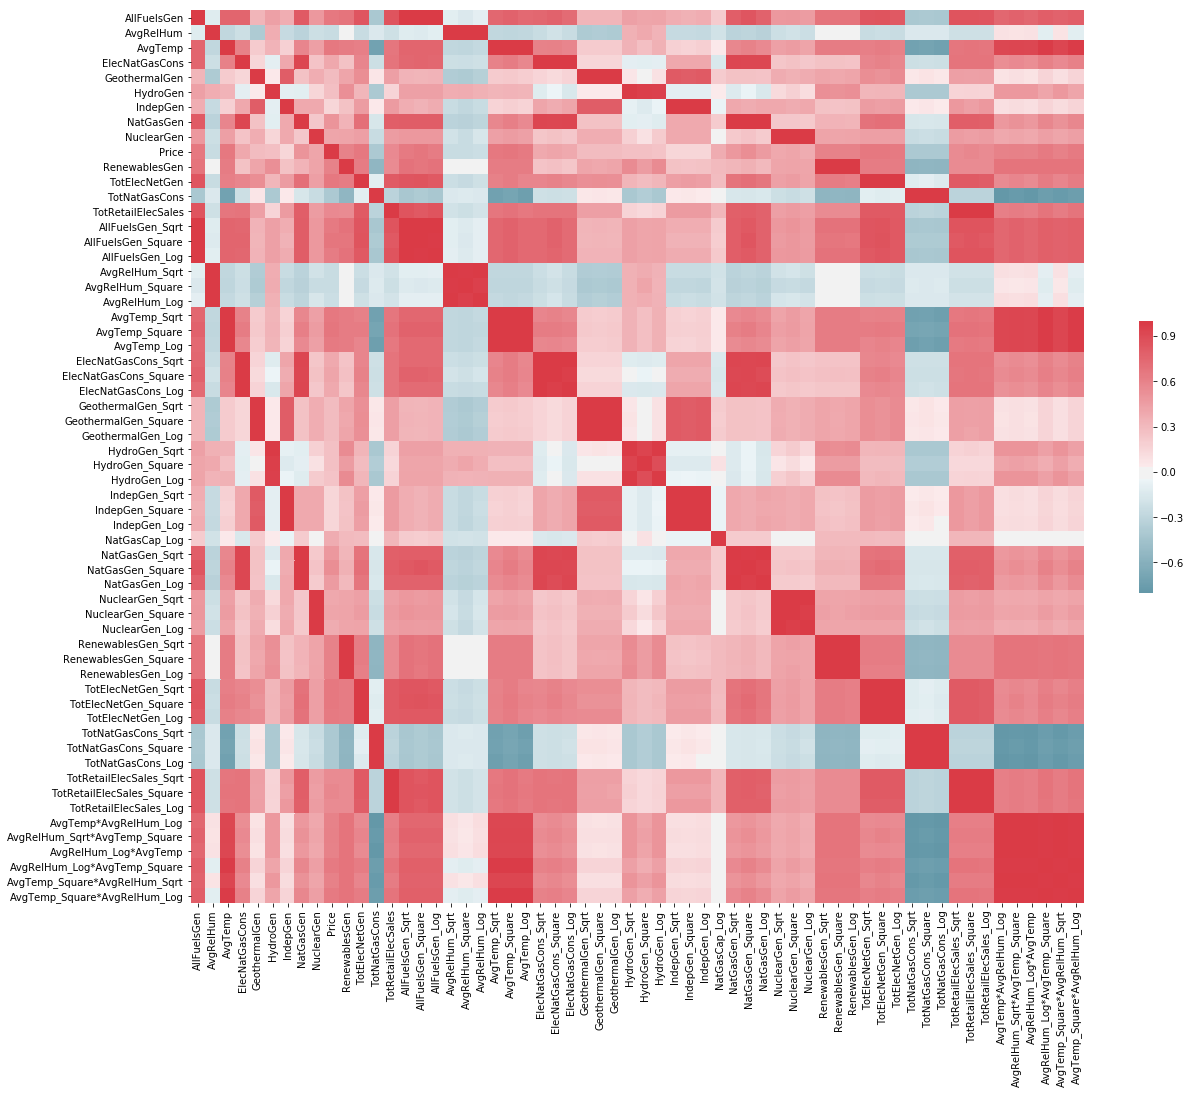

In [129]:
plt.close("all")
%run helper_functions.py 
reg_heatmap = reg_heat_map(new_new_data)
reg_heatmap

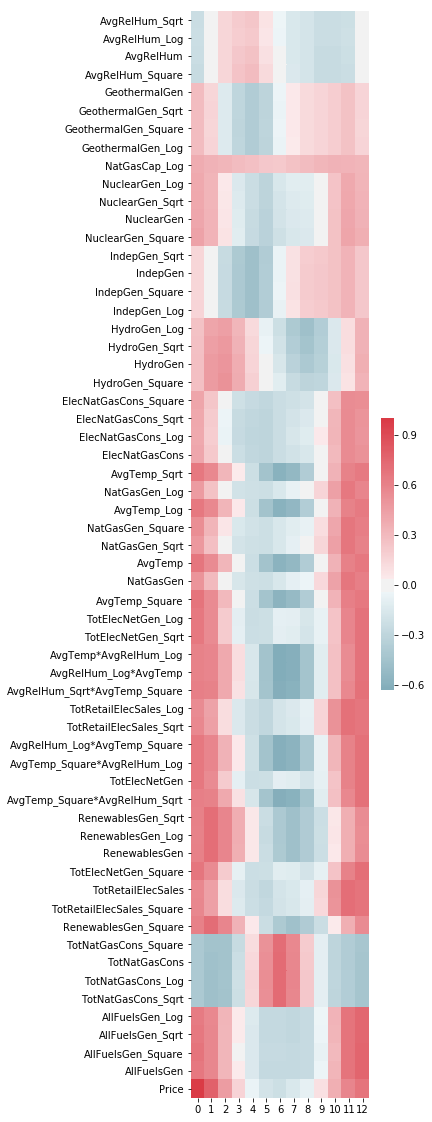

In [135]:
plt.close("all")
%run helper_functions.py 
time_heatmap = time_heat_map(new_new_data,'Price',months=12)
time_heatmap

## Create Test Matrix of Model/Feature Combinations

Pandas dataframe with:

Columns: Features, Hyperparameters, 1 column for model type, 1 column for average test results
Rows: Different combinations of the above
Data: 1's and 0's for feature inclusion, hyperparameter values, average test results

## Run Test Matrix of Model/Feature Combinations

Run many separate model trainings & performance tests for each combination below, averaging the __test__ results:

[ML algorithm X hyperparameter set X feature grouping]

Fill out pandas dataframe with average performance test results.


## Visualize Performance Matrix

Display test results graphically.

## Make Predictions

## New Thoughts

Maybe predicting a signal is not one model... it can be a collection of models that are each responsible for predicting a single future timestep. Each part of the future will have different dependencies on the past. Each time delta (e.g. +5 months in the future) should then be trained as a separate model. These models' predictions would be combined and smoothed to form a cohesive prediction signal. 

We can first construct an enormous set of features using transformations: square, log, exponent, derivative, integral. Then combinations of these: product, quotient, exponent. Then maybe even transformations of the combinations! We can easily turn 20 features that we think might have some unique substance into several million, producing and exploring nonlinear relationships by force.

We can filter features as they are constructed based on some basic correlation criteria (too correlated with others, uncorrelated with price).

This would be to perform manageable LassoCV (= Lasso + regularization) regressions for each future timestep. Lasso automatically selects the best few features, even from many thousands. We would normalize all features before running Lasso, but after doing feature construction.

This strategy is forcing a complex future prediction problem into a linear regression mold. It allows classic test-train splitting, which means we can have an accurate understanding of our ultimate predictive power. 

The time delay aspect of feature construction will be the most interesting I believe. Training for a model whose job is to predict the 5 month future price will match the y_train signal with x_train signals from 5 months in the past and before. And before? ... For a 5 month future prediction, I hypothesize that we won't just want to look at a 5 month old slice of signals. Rather, we want to look at the whole body of data from 5 months ago and further back into the past. All of a particular future price's 6 month old, 7 month old, 1 year old data become features of that price. This is some seriously epic dataframe manipulation.

ARMA, ARIMA, SARIMA are time series forecasting models that also look into the past, but quite differently (these models are actually univariate... the multivariate one is call VAR (vector auto-regression) which works for our case, where we think other signals are influencing the signal we are interested in.

In [3]:

from sklearn.linear_model import LassoCV